In [70]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df_cleaned_esf = pd.read_excel('data/df_cleaned_esf.xlsx')
df_cleaned_zu = pd.read_excel('data/df_cleaned_zu.xlsx')

In [72]:
df_dummies1 = pd.get_dummies(df_cleaned_esf['location'], prefix='location').astype(int)
df_model1 = pd.concat([
            df_cleaned_esf[['unit', 'square']].reset_index(drop=True),
            df_dummies1.reset_index(drop=True)
            ], axis=1)
df_model1 = df_model1.apply(pd.to_numeric, errors='coerce').dropna()


In [73]:
location_cols_model1 = [col for col in df_dummies1.columns if col != 'location_上地']
X_esf = df_model1[['square'] + location_cols_model1].values
y_esf = df_model1['unit'].values

In [74]:
model1 = LinearRegression()
model1.fit(X_esf, y_esf)

LinearRegression()

In [75]:
feature_names= ['square', 'location_qinghe','location_xierqi','location_xisanqi'] 

In [76]:
r_squared_model1= model1.score(X_esf, y_esf)

In [77]:
df_dummies2 = pd.get_dummies(df_cleaned_zu['location'], prefix='location').astype(int)
df_model2 = pd.concat([
            df_cleaned_zu[['rent_per_m2','square']].reset_index(drop=True),
            df_dummies2.reset_index(drop=True)
            ], axis=1)
df_model2 = df_model2.apply(pd.to_numeric, errors='coerce').dropna()

In [78]:
location_cols_model2= [col for col in df_dummies2.columns if col != 'location_上地']
X_rent = df_model2[['square'] + location_cols_model2].values
y_rent = df_model2['rent_per_m2'].values

In [79]:
model2 = LinearRegression()
model2.fit(X_rent, y_rent)

LinearRegression()

In [80]:
r_squared_model2= model2.score(X_rent, y_rent)

In [81]:
def get_location_from_features(features, feature_names):
    """Extract location information from the feature array"""
    locations = []
    for i in range(len(features)):
        if features[i, 1] == 1:  # location_qinghe
            locations.append('清河')
        elif features[i, 2] == 1:  # location_xierqi
            locations.append('西二旗')
        elif features[i, 3] == 1:  # location_xisanqi
            locations.append('西三旗')
        else:  # 默认是上地
            locations.append('上地')
    return locations

In [82]:
#use model1 to predict price/m2
locations_esf_predict=get_location_from_features(X_rent, feature_names)
df_y_esf_predict = pd.DataFrame({
    'location': locations_esf_predict,
    'predicted_price_per_m2': model1.predict(X_rent)
})
df_y_esf_predict['price_rent_ratio_model1']=df_y_esf_predict['predicted_price_per_m2']/(df_cleaned_zu['rent_per_m2']).astype(float)

In [83]:
#use model2 to predict rent/m2
locations_rent_predict=get_location_from_features(X_esf, feature_names)
df_y_rent_predict = pd.DataFrame({
    'location': locations_rent_predict,
    'predicted_rent_per_m2': model2.predict(X_esf)
})
df_y_rent_predict['price_rent_ratio_model2']=(df_cleaned_esf['unit'])/df_y_rent_predict['predicted_rent_per_m2'].astype(float)

In [84]:
median_ratios_model1 = df_y_esf_predict.groupby('location')['price_rent_ratio_model1'].median()
print("Median rent-to-price ratio by region calculated using Model1 to predict house prices and actual rents:")
for location in ['上地', '清河', '西二旗', '西三旗']:
    if location in median_ratios_model1:
        print(f"{location}: {median_ratios_model1[location]:.4f}")

Median rent-to-price ratio by region calculated using Model1 to predict house prices and actual rents:
上地: 859.5513
清河: 976.2220
西二旗: 723.3907
西三旗: 704.7775


In [85]:
median_ratios_model2 = df_y_rent_predict.groupby('location')['price_rent_ratio_model2'].median()
print("Median rent-to-price ratio by region calculated using Model2 to predict house prices and actual rents:")
for location in ['上地', '清河', '西二旗', '西三旗']:
    if location in median_ratios_model2:
        print(f"{location}: {median_ratios_model2[location]:.4f}")

Median rent-to-price ratio by region calculated using Model2 to predict house prices and actual rents:
上地: 949.2404
清河: 1382.8128
西二旗: 764.4437
西三旗: 668.0704


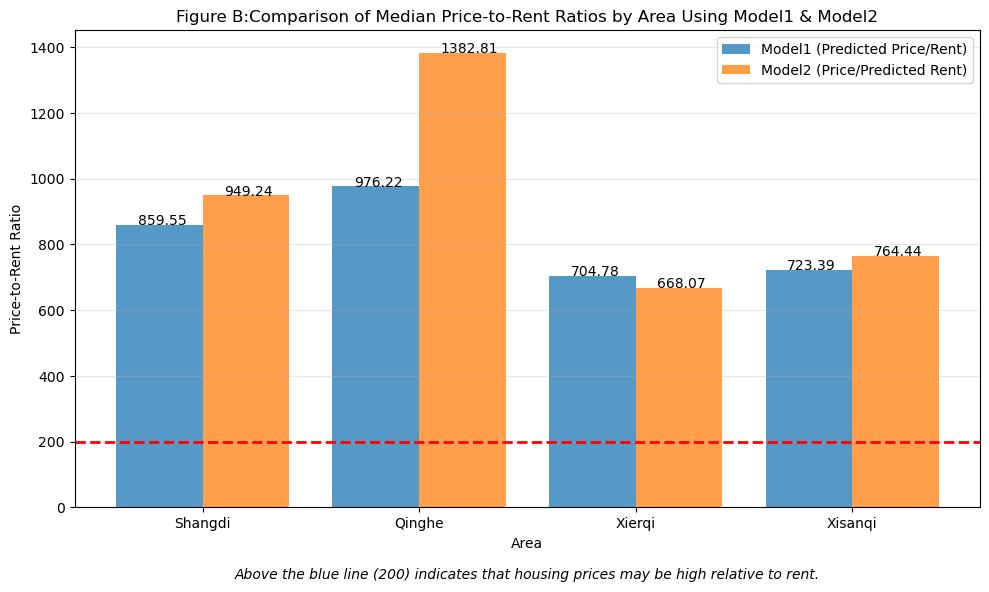

In [86]:
# Bar Plot the median price to rent ratio for each block by using model1 and model2
locations = ['Shangdi', 'Qinghe', 'Xierqi', 'Xisanqi']

x = range(len(locations))

fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(x, median_ratios_model1.values, width=0.4, label='Model1 (Predicted Price/Rent)', alpha=0.75)
plt.bar([i + 0.4 for i in x], median_ratios_model2.values, width=0.4, label='Model2 (Price/Predicted Rent)', alpha=0.75)

plt.xlabel('Area')
plt.ylabel('Price-to-Rent Ratio')
plt.title('Figure B:Comparison of Median Price-to-Rent Ratios by Area Using Model1 & Model2')
plt.xticks([i + 0.2 for i in x], locations)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(median_ratios_model1.values):
    plt.text(i - 0.1, v + 0.01, f'{v:.2f}', color='black')
for i, v in enumerate(median_ratios_model2.values):
    plt.text(i + 0.3, v + 0.01, f'{v:.2f}', color='black')

# Add explanatory text
global_fair_value = 200
ax.axhline(y=global_fair_value, color='red', linestyle='--', linewidth=2, 
           label=f'Global Fair Value ({global_fair_value})')
ax.text(0.5, -0.15, 
        f"Above the blue line ({global_fair_value}) indicates that housing prices may be high relative to rent.", 
        transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

In [87]:
#Modeling Pro Max
#Model 1+
df_model1_plus = df_model1.copy()
df_model1_plus['square_sq'] = df_model1_plus['square'] ** 2
for loc_col in location_cols_model1:
    df_model1_plus[f'square_{loc_col}'] = df_model1_plus['square'] * df_model1_plus[loc_col]
feature_cols_plus = (['square', 'square_sq'] + location_cols_model1 + 
                    [f'square_{loc}' for loc in location_cols_model1])
X_esf_plus = df_model1_plus[feature_cols_plus].values  
model1_plus = LinearRegression()
model1_plus.fit(X_esf_plus, y_esf)
r_squared_model1_plus = model1_plus.score(X_esf_plus, y_esf)

In [88]:
#Model 2+
df_model2_plus = df_model2.copy()
df_model2_plus['square_sq'] = df_model2_plus['square'] ** 2
for loc_col in location_cols_model2:
    df_model2_plus[f'square_{loc_col}'] = df_model2_plus['square'] * df_model2_plus[loc_col]
feature_cols_plus = (['square', 'square_sq'] + location_cols_model2 + 
                    [f'square_{loc}' for loc in location_cols_model2])
X_rent_plus = df_model2_plus[feature_cols_plus].values  
model2_plus = LinearRegression()
model2_plus.fit(X_rent_plus, y_rent)
r_squared_model2_plus = model2_plus.score(X_rent_plus, y_rent)

In [89]:
#use model 1+ to predict price/m2
df_y_esf_predict_plus = pd.DataFrame({
    'location': locations_esf_predict,
    'predicted_price_per_m2': model1_plus.predict(X_rent_plus)
})
df_y_esf_predict_plus['price_rent_ratio_model1']=df_y_esf_predict_plus['predicted_price_per_m2']/(df_cleaned_zu['rent_per_m2']).astype(float)

In [90]:
median_ratios_model1_plus = df_y_esf_predict_plus.groupby('location')['price_rent_ratio_model1'].median()
print("Using Model1+ to predict house prices and calculate the median rent-to-price ratio of each region based on actual rents:")
for location in ['上地', '清河', '西二旗', '西三旗']:
    if location in median_ratios_model1_plus:
        print(f"{location}: {median_ratios_model1_plus[location]:.4f}")

Using Model1+ to predict house prices and calculate the median rent-to-price ratio of each region based on actual rents:
上地: 902.3257
清河: 828.1338
西二旗: 717.5962
西三旗: 662.1922


In [91]:
#use model 2+ to predict rent/m2
df_y_rent_predict_plus = pd.DataFrame({
    'location': locations_rent_predict,
    'predicted_rent_per_m2': model2_plus.predict(X_esf_plus)
})
df_y_rent_predict_plus['price_rent_ratio_model2']=(df_cleaned_esf['unit'])/df_y_rent_predict_plus['predicted_rent_per_m2'].astype(float)

In [92]:
median_ratios_model2_plus = df_y_rent_predict_plus.groupby('location')['price_rent_ratio_model2'].median()
print("Using Model2 to predict house prices and calculate the median rent-to-price ratio of each region based on actual rents:")
for location in ['上地', '清河', '西二旗', '西三旗']:
    if location in median_ratios_model2_plus:
        print(f"{location}: {median_ratios_model2_plus[location]:.4f}")

Using Model2 to predict house prices and calculate the median rent-to-price ratio of each region based on actual rents:
上地: 897.2761
清河: 937.9136
西二旗: 760.2826
西三旗: 685.5121


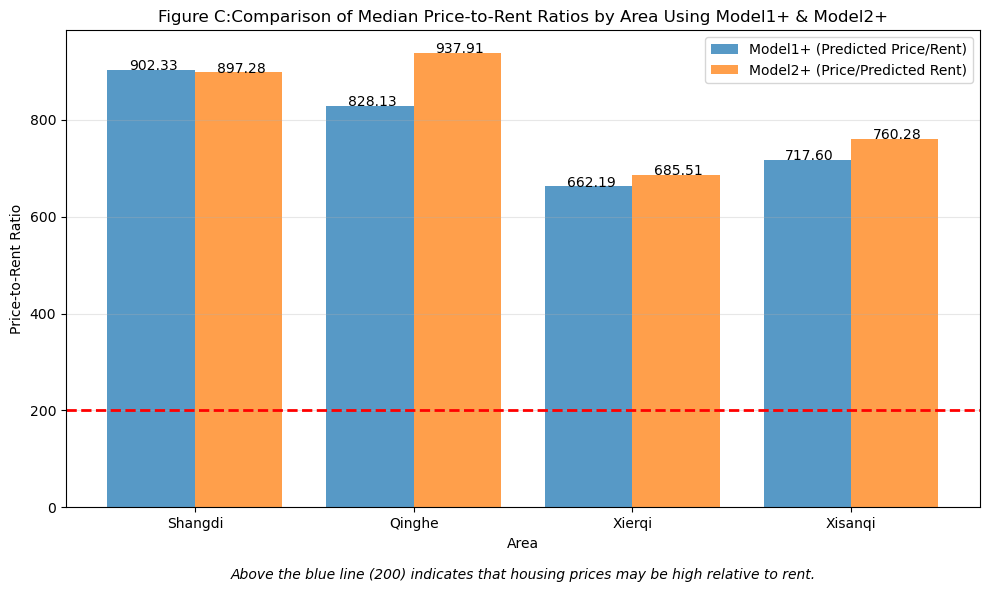

In [93]:
# Bar Plot the median price to rent ratio for each block by using model1+ and model2+
locations = ['Shangdi', 'Qinghe', 'Xierqi', 'Xisanqi']
x = range(len(locations))

fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(x, median_ratios_model1_plus.values, width=0.4, label='Model1+ (Predicted Price/Rent)', alpha=0.75)
plt.bar([i + 0.4 for i in x], median_ratios_model2_plus.values, width=0.4, label='Model2+ (Price/Predicted Rent)', alpha=0.75)

plt.xlabel('Area')
plt.ylabel('Price-to-Rent Ratio')
plt.title('Figure C:Comparison of Median Price-to-Rent Ratios by Area Using Model1+ & Model2+')
plt.xticks([i + 0.2 for i in x], locations)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(median_ratios_model1_plus.values):
    plt.text(i - 0.1, v + 0.01, f'{v:.2f}', color='black')
for i, v in enumerate(median_ratios_model2_plus.values):
    plt.text(i + 0.3, v + 0.01, f'{v:.2f}', color='black')

# Add explanatory text
global_fair_value = 200
ax.axhline(y=global_fair_value, color='red', linestyle='--', linewidth=2, 
           label=f'Global Fair Value ({global_fair_value})')
ax.text(0.5, -0.15, 
        f"Above the blue line ({global_fair_value}) indicates that housing prices may be high relative to rent.", 
        transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

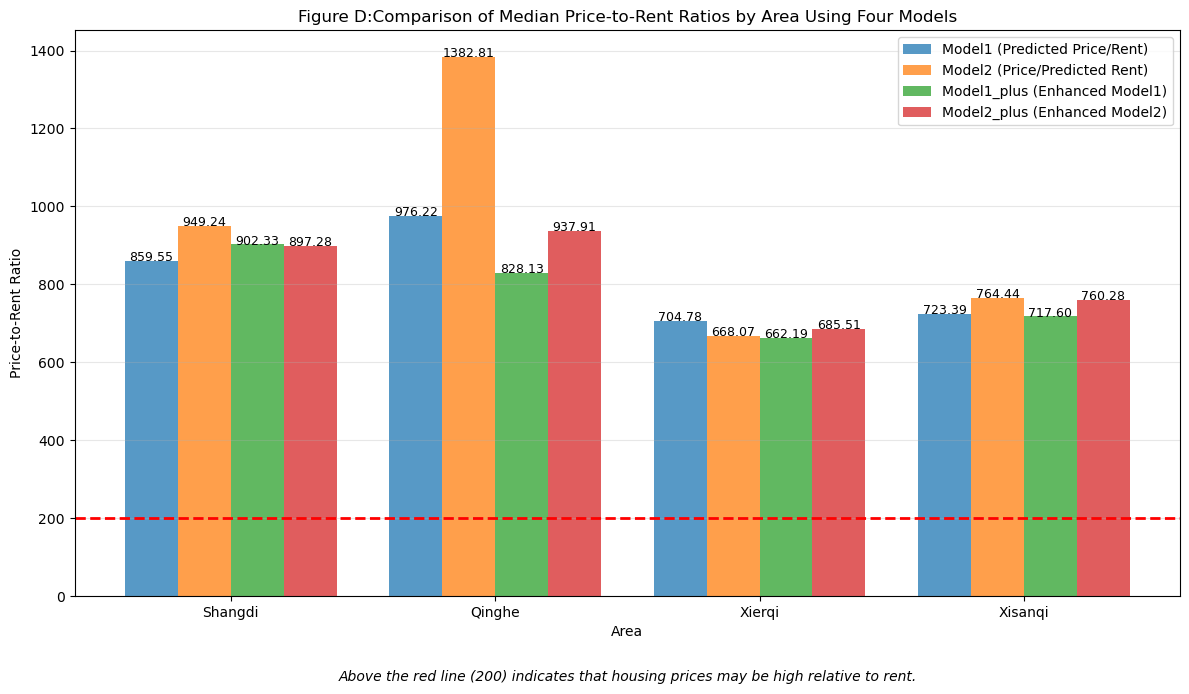

In [94]:
locations = ['Shangdi', 'Qinghe', 'Xierqi', 'Xisanqi']

x = range(len(locations))

fig, ax = plt.subplots(figsize=(12, 7))  

# Set the position and width of the bar chart
width = 0.2  # Width of each column
offset = width * 1.5  # Spacing Between Columns

# Draw bar charts for four models
plt.bar([i - offset for i in x], median_ratios_model1.values, width=width, 
        label='Model1 (Predicted Price/Rent)', alpha=0.75)
plt.bar([i - width/2 for i in x], median_ratios_model2.values, width=width, 
        label='Model2 (Price/Predicted Rent)', alpha=0.75)
plt.bar([i + width/2 for i in x], median_ratios_model1_plus.values, width=width, 
        label='Model1_plus (Enhanced Model1)', alpha=0.75)
plt.bar([i + offset for i in x], median_ratios_model2_plus.values, width=width, 
        label='Model2_plus (Enhanced Model2)', alpha=0.75)

plt.xlabel('Area')
plt.ylabel('Price-to-Rent Ratio')
plt.title('Figure D:Comparison of Median Price-to-Rent Ratios by Area Using Four Models')
plt.xticks(x, locations)  # Place the tick labels at the center of each group of regions
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(median_ratios_model1.values):
    plt.text(i - offset, v + 0.01, f'{v:.2f}', color='black', ha='center', fontsize=9)
for i, v in enumerate(median_ratios_model2.values):
    plt.text(i - width/2, v + 0.01, f'{v:.2f}', color='black', ha='center', fontsize=9)
for i, v in enumerate(median_ratios_model1_plus.values):
    plt.text(i + width/2, v + 0.01, f'{v:.2f}', color='black', ha='center', fontsize=9)
for i, v in enumerate(median_ratios_model2_plus.values):
    plt.text(i + offset, v + 0.01, f'{v:.2f}', color='black', ha='center', fontsize=9)

# Add explanatory text
global_fair_value = 200
ax.axhline(y=global_fair_value, color='red', linestyle='--', linewidth=2, 
           label=f'Global Fair Value ({global_fair_value})')
ax.text(0.5, -0.15, 
        f"Above the red line ({global_fair_value}) indicates that housing prices may be high relative to rent.", 
        transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

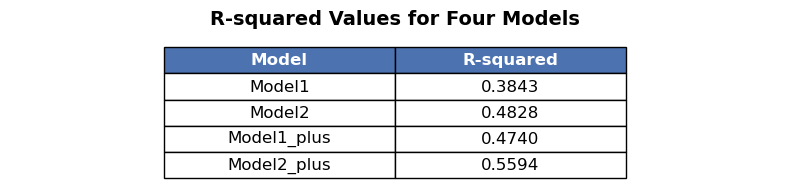

In [95]:
# Create table
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')

# Create table data
table_data = [
    ['Model', 'R-squared'],
    ['Model1', f'{r_squared_model1:.4f}'],
    ['Model2', f'{r_squared_model2:.4f}'],
    ['Model1_plus', f'{r_squared_model1_plus:.4f}'],
    ['Model2_plus', f'{r_squared_model2_plus:.4f}']
]


table = ax.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.3, 0.3])

# Set table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Set header row style
for i in range(2):
    table[(0, i)].set_facecolor('#4C72B0')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('R-squared Values for Four Models', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Evaluation:  
### Method 1: Use the median price per unit area of houses divided by the median rent per unit area.  
*Advantages:*  
- Simple and easy: The calculation is straightforward and does not require complex models or assumptions.  
- Intuitive: Easy to understand and explain, as it is directly based on the median, which reduces the impact of outliers.  
- Robustness: The median is not sensitive to outliers, so the rent-to-price ratio estimate is relatively robust.

*Disadvantages:*  
- Information loss: Only the median is used, ignoring the distribution and other characteristics of the data.  
- Possible inaccuracy: If the distributions of house prices and rents are different, the median ratio may not represent a typical rent-to-price ratio.
- Not suitable for heterogeneous markets: In cases where the real estate market is highly heterogeneous (such as significant differences between regions), this method may produce misleading results.   

### Method 2: Estimation Using Linear Models  
*Advantages:*  
- Utilize More Information: Linear models can include multiple variables, thereby capturing more factors that affect the rent-to-sale ratio.  
- Flexibility: The model can be improved by selecting different independent variables.  
- Statistical Inference: Provides confidence intervals and hypothesis tests to assess the reliability of estimates.  

*Disadvantages:*  
- Model Assumptions: Linear models assume a linear relationship between variables, which may not always hold.
- Risk of overfitting: If there are too many variables or the sample size is small, the model may overfit the training data and have poor generalization ability.
- Complexity: More complex than Method 1, requiring statistical knowledge and software.  

### Method 3: Linear Model Fit Estimation with Added Nonlinear Variables  
*Advantages:*  
- Capture Nonlinear Relationships: Can model the nonlinear relationship between house prices and rents, improving model accuracy.  
- More Realistic: In the real world, relationships are often nonlinear, so this method may be more accurate.  
- Flexibility: By adding appropriate nonlinear terms, the data can be fitted better.  

*Disadvantages:*  
- Increased Complexity: The model becomes more complex and requires choosing which nonlinear terms to include, possibly through model selection techniques.
- Higher risk of overfitting: Adding too many nonlinear terms or interaction terms can easily lead to overfitting, especially in small samples, and requires regularization or cross-validation.  
- Computational Cost: Requires more computational resources and statistical expertise.  

### Summary  
Method 1 is used for small sample data, while Methods 2 and 3 can be used for large sample data.  
<b>In this case, the sample size is relatively large. Comparing the R-squared values obtained by the latter two methods, the third method is the most reliable. Among them, Model2+ has the best fit.</b>